# Data & Apprentissage, M2CHPS

## Assignments - Part 1

**Lecturer:** [Argyris Kalogeratos](http://kalogeratos.com) (contact: argyris.kalogeratos@ens-paris-saclay.fr).   
**Sylabus:** [http://nvayatis.perso.math.cnrs.fr/CHPScourse-2024.html](http://nvayatis.perso.math.cnrs.fr/CHPScourse-2023.html)

The most updated version of this file can be found at the webpage:  
[http://kalogeratos.com/MyCourses/DML-M2HPC/Assignments1.ipynb](http://kalogeratos.com/psite/files/MyCourses/DML-M2HPC/Assignments1.ipynb).

## 0. Before you start

* Work on the assignment either alone or in a team of two (pair). Students that will work alone will benefit from a 15% bonus. Important: The point in working in a pair is not to split the work, but to collaborate! 
* Prepare **a single jupiter notebook** in a report-like format for all the exercises. Use this notebook as a starting point and place your answers just below each exercise. Describe properly what you do in each step of your solution, followed by your well-commented code implementation that can automatically produce figures and numerical results. Results should also be well-commented and discussed. Your comments can be either in English or in French.
* If you need to provide mathematical expressions, incorporate all that in your notebook in a latex form (not handwritten!). 
* Important: send your notebook that includes all your work and any additional files you used (e.g. datasets) at by email, with a title ``M2CHPS <year> - <Surname1> & <Surname2>``. The title of the notebook should have the surnames of the students. The body of the email should also mention the students' names and how the work was split among them; if you face difficulties in precising this with your classmate, please write individual emails. 
* Always use references for things you reuse (e.g. internet, forums, books, published papers, etc.)
* Do not copy-paste from the internet recipies that do the asked thing (or what is most usually observed: to use something relevant but not exactly what is asked). You need to understand what you use (sources should be properly referenced), adapt it to what each exercise asks for, and comment clearly the results. Poorly commented and explained pieces of work/code will not be taken seriously into account. 
* Copying from one another is not acceptable. We are strict with that: cheating in even one exercise will incur **a zero to all projects** (not just one assignement) and possible disqualification from the exams. Your work will be cross-checked against anything similar submitted from past students of the course.
* The assignments will be examined orally at the end of the semester. Each group of students should be able to explain in about 10 mins all what they did, and answer short questions.
* **Deadline: midnight of Monday 20/10**. 

## Exercise 1 - [30%]
Read about the iterative [RANdom SAmple Consensus (RANSAC)](https://en.wikipedia.org/wiki/Random_sample_consensus) method for robust linear regression. Consult also the material of the Lab and the documentation of scikit learn.

**a)** Implement from scratch your own code for the RANSAC algorithm. You can still use as a building block the native linear regression of scikit learn in your implementation. Then, compare it with the simple linear regression and the build-in RANSAC implementation of scikit learn.

a1) Apply your solution to the dataset of the example given in [Lab 2](http://kalogeratos.com/MyCourses/DML-M2HPC/Lab2.ipynb) to see that it  matches the behavior of the already coded method of scikit learn. Create plots including the linear models found by the typical linear regressor, the scikit RANSAC, and you version(s).

a2) Apply your method to the following cases:
* Use only the part of the inliners that comes from the inclined linear model (about 1000 points). Add extra $p$% of noisy points (where $p$ can be 5%, 10%, 20%, 30%) by picking random elements of the data and perturbing them "sufficiently" with a Gaussian noise so that they get dislocated far from the rest of the data on both sides.
* Do as before, but constrain the perturbation to be only positive (all noisy points will be above the inline data).
* Do as before, but the perturbed data will not be randomly selected, but rather correspond to the $p$% of the points with lower $y$ coordinate (the points at the lower left part of the plot).

What differences do you observe among these cases. Report with illustrative results and comments. You can test additional cases using the same data generation code, after changing some of the parameters (e.g. the number of outliers and their distance to the inliers). 

Simple Linear Regression MSE: 0.7430610341321241
Sklearn RANSAC MSE: 1.599460963520926
Custom RANSAC MSE: 1.1726023896577755


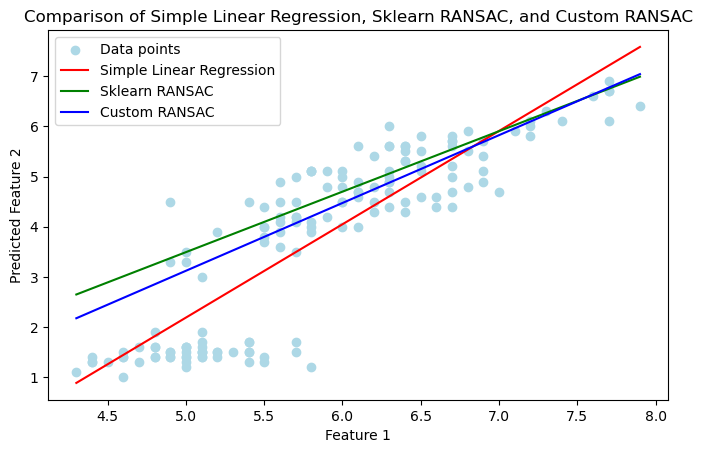

In [31]:
# a1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn import datasets

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, :1]  # Only use the first feature for simplicity (to make sure it's linear)
y = iris.data[:, 2]  # Predict one of the other features

# Custom RANSAC Algorithm implementation
def ransac(data, model, n, k, t, d):
    iterations = 0
    bestFit = None
    bestErr = float('inf')  # Initialize bestErr to a very large number
    
    X, y = data
    n_points = len(X)

    while iterations < k:
        # Randomly sample n points from the data to estimate model parameters
        maybe_inliers_idx = np.random.choice(n_points, n, replace=False)
        X_maybe_inliers = X[maybe_inliers_idx]
        y_maybe_inliers = y[maybe_inliers_idx]

        # Fit the model to the maybe inliers
        maybe_model = model()
        maybe_model.fit(X_maybe_inliers, y_maybe_inliers)

        # Identify confirmed inliers
        confirmed_inliers = []
        for i in range(n_points):
            y_pred = maybe_model.predict(X[i].reshape(1, -1))
            error = np.abs(y[i] - y_pred)
            if error < t:
                confirmed_inliers.append(i)

        # Check if we have a valid model (sufficient number of inliers)
        if len(confirmed_inliers) > d:
            X_confirmed_inliers = X[confirmed_inliers]
            y_confirmed_inliers = y[confirmed_inliers]

            # Refit the model with all inliers
            better_model = model()
            better_model.fit(X_confirmed_inliers, y_confirmed_inliers)

            # Calculate error (e.g., mean squared error)
            y_pred = better_model.predict(X_confirmed_inliers)
            thisErr = mean_squared_error(y_confirmed_inliers, y_pred)

            # If error is better than current best, update the best model
            if thisErr < bestErr:
                bestFit = better_model
                bestErr = thisErr

        iterations += 1

    return bestFit


# Set parameters for custom RANSAC
n = 10  # Minimum number of data points required to estimate the model
k = 100  # Maximum number of iterations
t = 0.5  # Threshold to determine inliers
d = 30  # Minimum number of inliers

# Custom RANSAC model
custom_ransac_model = ransac((X, y), LinearRegression, n, k, t, d)


# Simple Linear Regression
simple_lr = LinearRegression()
simple_lr.fit(X, y)
y_pred_simple = simple_lr.predict(X)
mse_simple = mean_squared_error(y, y_pred_simple)


# Sklearn Built-in RANSAC
sklearn_ransac = RANSACRegressor(estimator=LinearRegression(), min_samples=n, residual_threshold=t)  # Fixed 'estimator' argument
sklearn_ransac.fit(X, y)
y_pred_sklearn_ransac = sklearn_ransac.predict(X)
mse_sklearn_ransac = mean_squared_error(y, y_pred_sklearn_ransac)


# Custom RANSAC Predictions
if custom_ransac_model:
    y_pred_custom_ransac = custom_ransac_model.predict(X)
    mse_custom_ransac = mean_squared_error(y, y_pred_custom_ransac)
else:
    print("No valid model found for Custom RANSAC")
    mse_custom_ransac = None


# Compare results
print(f"Simple Linear Regression MSE: {mse_simple}")
print(f"Sklearn RANSAC MSE: {mse_sklearn_ransac}")
if mse_custom_ransac is not None:
    print(f"Custom RANSAC MSE: {mse_custom_ransac}")
else:
    print("Custom RANSAC did not find a good model.")


# Sort data for plotting
sorted_idx = np.argsort(X[:, 0])  # Sort by the first feature
X_sorted = X[sorted_idx]
y_sorted = y[sorted_idx]

# Sort predictions according to the sorted indices
y_pred_simple_sorted = y_pred_simple[sorted_idx]
y_pred_sklearn_ransac_sorted = y_pred_sklearn_ransac[sorted_idx]
if custom_ransac_model:
    y_pred_custom_ransac_sorted = y_pred_custom_ransac[sorted_idx]

# Plot the results for comparison
plt.figure(figsize=(8, 4.8))

# Original data points
plt.scatter(X[:, 0], y, color="lightblue", label="Data points")

# Simple Linear Regression
plt.plot(X_sorted[:, 0], y_pred_simple_sorted, color="red", label="Simple Linear Regression")

# Sklearn RANSAC
plt.plot(X_sorted[:, 0], y_pred_sklearn_ransac_sorted, color="green", label="Sklearn RANSAC")

# Custom RANSAC
if custom_ransac_model:
    plt.plot(X_sorted[:, 0], y_pred_custom_ransac_sorted, color="blue", label="Custom RANSAC")

plt.legend()
plt.title("Comparison of Simple Linear Regression, Sklearn RANSAC, and Custom RANSAC")
plt.xlabel("Feature 1")
plt.ylabel("Predicted Feature 2")
plt.show()


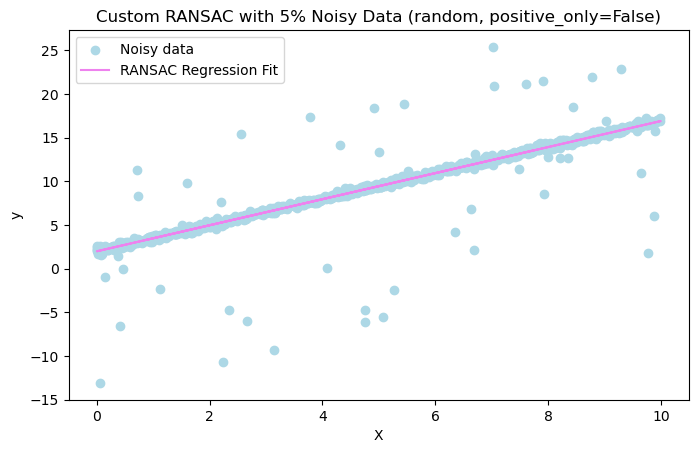

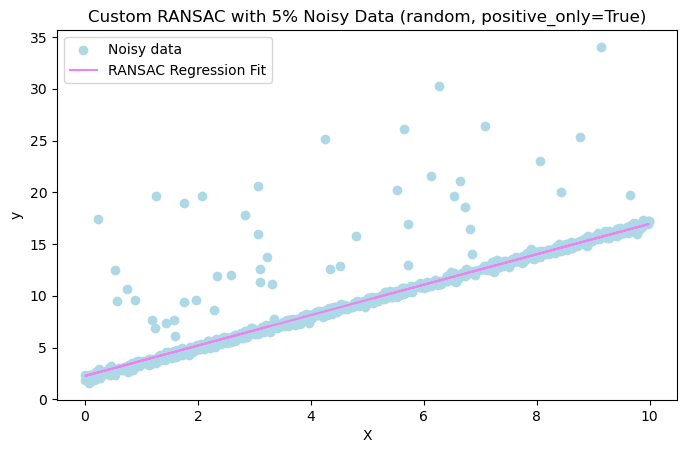

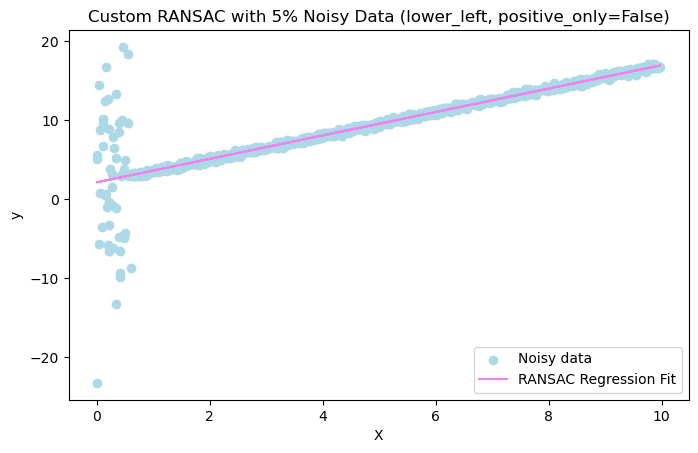

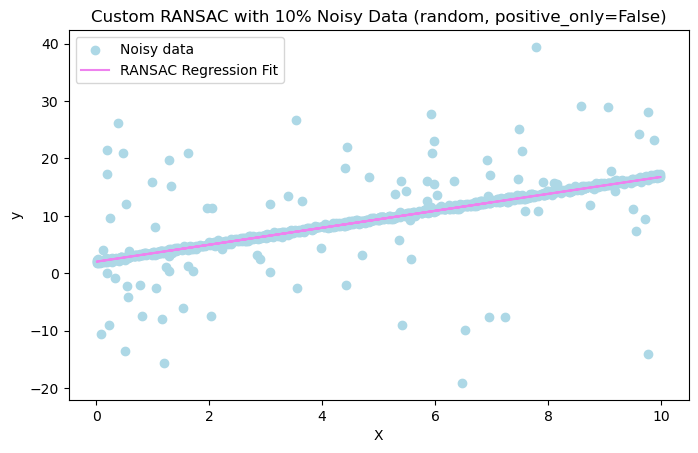

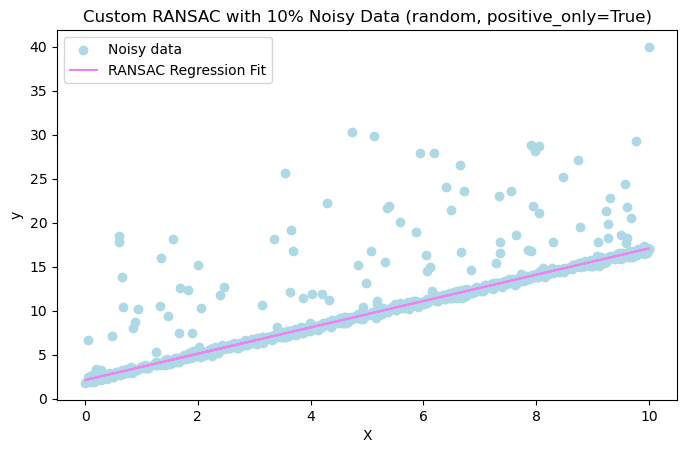

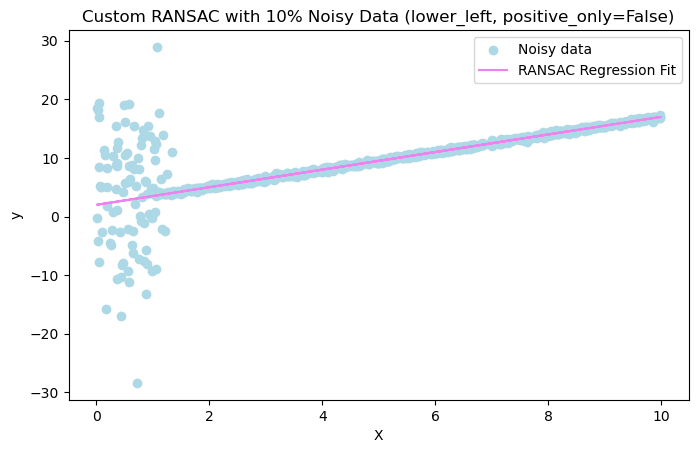

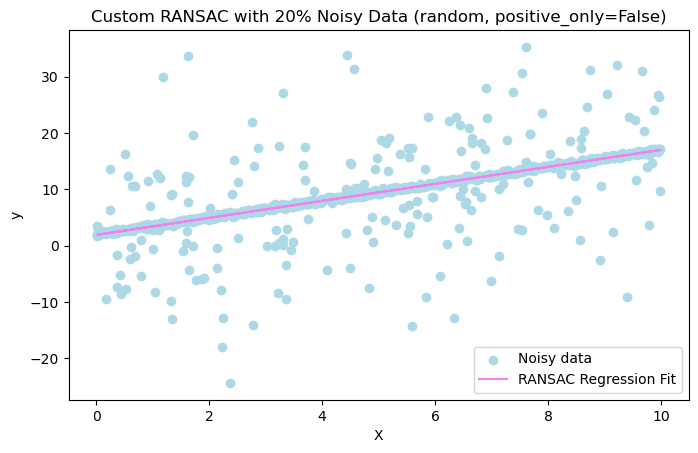

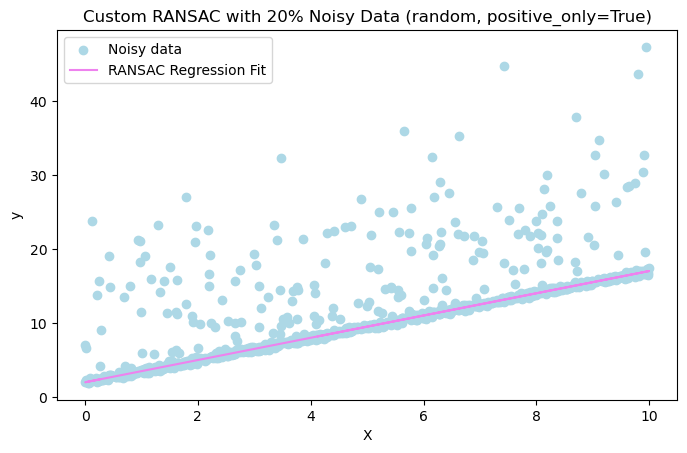

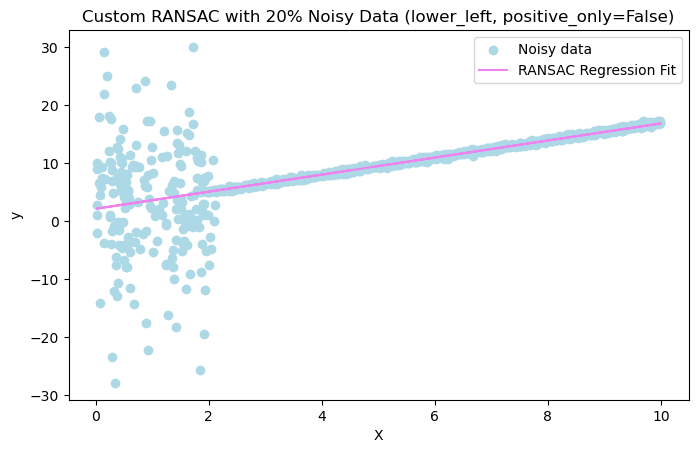

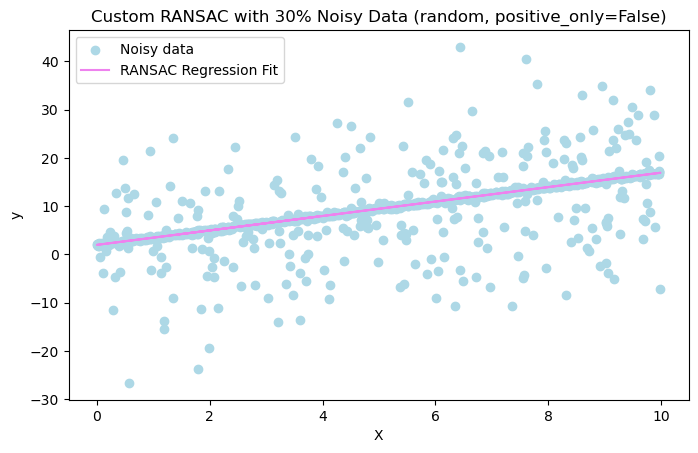

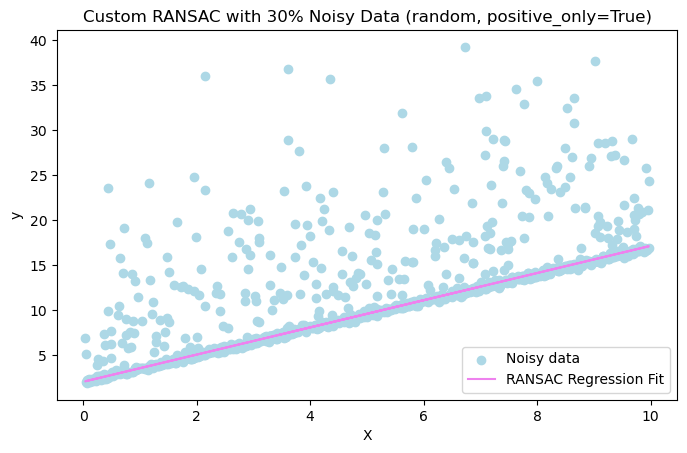

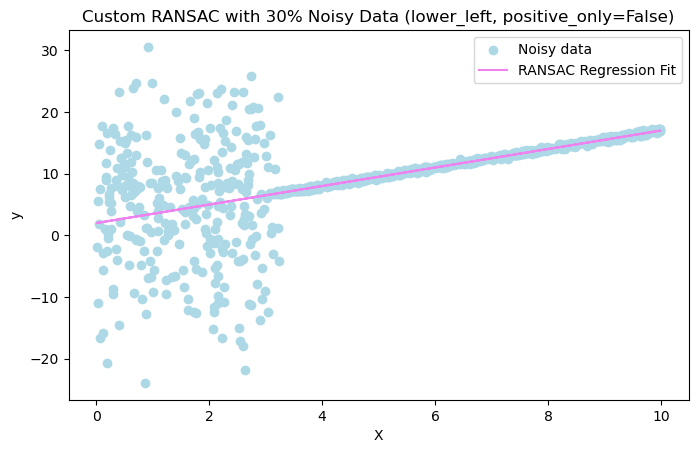

In [47]:
# a2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Custom RANSAC Algorithm implementation (same as before)
def ransac(data, model, n, k, t, d):
    iterations = 0
    bestFit = None
    bestErr = float('inf')  # Initialize bestErr to a very large number
    
    X, y = data
    n_points = len(X)

    while iterations < k:
        # Randomly sample n points from the data to estimate model parameters
        maybe_inliers_idx = np.random.choice(n_points, n, replace=False)
        X_maybe_inliers = X[maybe_inliers_idx]
        y_maybe_inliers = y[maybe_inliers_idx]

        # Fit the model to the maybe inliers
        maybe_model = model()
        maybe_model.fit(X_maybe_inliers, y_maybe_inliers)

        # Identify confirmed inliers
        confirmed_inliers = []
        for i in range(n_points):
            y_pred = maybe_model.predict(X[i].reshape(1, -1))
            error = np.abs(y[i] - y_pred)
            if error < t:
                confirmed_inliers.append(i)

        # Check if we have a valid model (sufficient number of inliers)
        if len(confirmed_inliers) > d:
            X_confirmed_inliers = X[confirmed_inliers]
            y_confirmed_inliers = y[confirmed_inliers]

            # Refit the model with all inliers
            better_model = model()
            better_model.fit(X_confirmed_inliers, y_confirmed_inliers)

            # Calculate error (e.g., mean squared error)
            y_pred = better_model.predict(X_confirmed_inliers)
            thisErr = mean_squared_error(y_confirmed_inliers, y_pred)

            # If error is better than current best, update the best model
            if thisErr < bestErr:
                bestFit = better_model
                bestErr = thisErr

        iterations += 1

    return bestFit


# Generate inline data for the inclined linear model
def generate_inliner_data(n_points=1000, slope=1.5, intercept=2.0, noise_std=0.2):
    X = np.random.rand(n_points, 1) * 10  # Random X values in [0, 10]
    y = slope * X + intercept + np.random.randn(n_points, 1) * noise_std  # Linear model with Gaussian noise
    return X, y

# Add noisy points by perturbing randomly selected points from the inliner data
def add_noisy_points(X, y, p, mode='random', positive_only=False):
    n_noisy = int(p * X.shape[0] / 100)  # Number of noisy points
    X_noisy, y_noisy = np.copy(X), np.copy(y)
    
    if mode == 'random':
        # Randomly select p% of points to add noise
        noisy_idx = np.random.choice(X.shape[0], n_noisy, replace=False)
    elif mode == 'lower_left':
        # Select the points with the lowest y-values (bottom left)
        noisy_idx = np.argsort(y[:, 0])[:n_noisy]
    
    for idx in noisy_idx:
        noise = np.random.randn() * 10  # Large Gaussian noise
        if positive_only:
            y_noisy[idx] += np.abs(noise)  # Ensure noise is positive
        else:
            y_noisy[idx] += noise  # Random positive or negative noise
    
    return X_noisy, y_noisy

# Plotting the results
def plot_ransac_results(X, y, y_pred, title):
    plt.figure(figsize=(8, 4.8))
    plt.scatter(X, y, color="lightblue", label="Noisy data")
    plt.plot(X, y_pred, color="violet", label="RANSAC Regression Fit")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()


# Apply the method for the three cases
def run_ransac_with_noisy_data(p, mode='random', positive_only=False):
    # Generate inliner data
    X_inliners, y_inliners = generate_inliner_data()

    # Add noisy points
    X_noisy, y_noisy = add_noisy_points(X_inliners, y_inliners, p, mode, positive_only)

    # Apply custom RANSAC
    custom_ransac_model = ransac((X_noisy, y_noisy), LinearRegression, n=50, k=200, t=1.0, d=50)
    
    # Generate predictions for the full dataset
    y_pred_custom_ransac = custom_ransac_model.predict(X_noisy)

    # Plot the results
    plot_ransac_results(X_noisy, y_noisy, y_pred_custom_ransac, f"Custom RANSAC with {p}% Noisy Data ({mode}, positive_only={positive_only})")


# Running for different cases
for i in [5, 10, 20, 30]:
    run_ransac_with_noisy_data(i, mode='random', positive_only=False)
    run_ransac_with_noisy_data(i, mode='random', positive_only=True)
    run_ransac_with_noisy_data(i, mode='lower_left', positive_only=False)


## Exercise 1 - [30%]

**b)** The original RANSAC uses inlying data points as votes for candidate models. An alternative is to use the opposite approach: i.e. to use the models to vote for the most inlying points. Implement this variation that operates as follows:
- Each time you subsample from the data, build a linear model, all inliers get a vote +1.
- After having built the predefined number of models, use the top q% (e.g. 75%) voted points and build the final linear model using only those points.

Use the previous dataset or/and other variations you may generate to demonstrate differences in performance, and discuss the results.

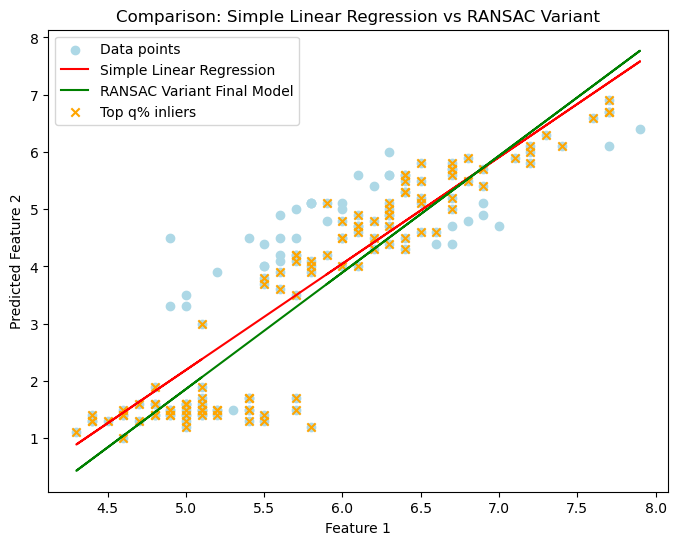

Simple Linear Regression MSE: 0.7430610341321241
RANSAC Variant Final Model MSE: 0.7979870002239515


In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, :1]  # Use only the first feature (to simplify linear regression)
y = iris.data[:, 2]   # Use another feature as the target variable

# Custom RANSAC variant function
def ransac_variant(X, y, n_samples, n_models, threshold, q):
    n_points = len(X)
    votes = np.zeros(n_points)  # Initialize votes for each data point
    
    for _ in range(n_models):
        # Randomly sample n_samples points to fit a model
        sample_indices = np.random.choice(n_points, n_samples, replace=False)
        X_sample = X[sample_indices]
        y_sample = y[sample_indices]

        # Fit a linear model to the sampled data
        model = LinearRegression()
        model.fit(X_sample, y_sample)

        # Calculate the residuals (prediction error) for all points
        y_pred = model.predict(X)
        residuals = np.abs(y - y_pred)

        # Vote for inliers where residuals are below the threshold
        inliers = residuals < threshold
        votes[inliers] += 1

    # Select the top q% points with the most votes
    top_q_percent = int(q * n_points)
    top_inliers_indices = np.argsort(votes)[-top_q_percent:]

    # Refit the final model using the top-voted inliers
    final_model = LinearRegression()
    final_model.fit(X[top_inliers_indices], y[top_inliers_indices])

    return final_model, top_inliers_indices

# Parameters for the RANSAC variant
n_samples = 30  # Number of points to sample each time
n_models = 500  # Total number of models to fit
threshold = 0.2  # Error threshold for identifying inliers
q = 0.75  # Use the top 75% voted points for the final model

# Fit the custom RANSAC variant model
final_model, top_inliers_indices = ransac_variant(X, y, n_samples, n_models, threshold, q)

# Predict using the final RANSAC variant model
y_pred_final = final_model.predict(X)

# Fit a simple linear regression model for comparison
simple_lr = LinearRegression()
simple_lr.fit(X, y)
y_pred_simple = simple_lr.predict(X)

# Plotting the results for comparison
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color="lightblue", label="Data points")  # Original data points
plt.plot(X, y_pred_simple, color="red", label="Simple Linear Regression")  # Simple linear regression line
plt.plot(X, y_pred_final, color="green", label="RANSAC Variant Final Model")  # Final model from RANSAC variant
plt.scatter(X[top_inliers_indices], y[top_inliers_indices], color="orange", label="Top q% inliers", marker="x")  # Top inliers

plt.title("Comparison: Simple Linear Regression vs RANSAC Variant")
plt.xlabel("Feature 1")
plt.ylabel("Predicted Feature 2")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error (MSE) for both models
mse_simple = mean_squared_error(y, y_pred_simple)
mse_final = mean_squared_error(y, y_pred_final)

print(f"Simple Linear Regression MSE: {mse_simple}")
print(f"RANSAC Variant Final Model MSE: {mse_final}")


## Exercise 1 - [30%]

**c)** As discussed in the class, the logic behind the RANSAC could actually be seen as a more general tool than just performing regression. More specifically, it can be seen as a way to perfom various kinds of *robust estimation*. 

<img src="./cloud-of-points-outliers.png" alt="Drawing" style="width: 500px;"/>

c1) Assume for example the problem where we have a point-cloud of data and we want to estimate their "center", as a group representative, but in a robust way. The figure above illustrates an example where the input data contains $100$ inliers and $10$ outliers, which however you don't know a priori. Here, the inliers come from a Gaussian distribution with $\mu = (0,0)$ and $\sigma = 0.83$, while the ouliers come from a Gaussian dislocated at $\mu = (0,0)$ and $\sigma = 1.5$. You can get the [.mat data file](http://kalogeratos.com/psite/files/MyCourses/DML-M2HPC/cloud-of-points-data.mat) with this example and/or write your own code to generate it. 

How would you design a solution to this problem that adopts the RANSAC principle so that for this kind of data input we can compute a representative as close as possible to the mean of the inliers?

c2) Extend this approach to the clustering of the data in a given number of $k$ clusters by considering a centroid-based clustering method (e.g. $k$-means) as the  internal model learner. Provide an implementation and demonstrate some example(s).

c3) Write an abstract pseudocode that expresses the generalization of RANSAC in arbitrary statistical estimation or learning problems? 

Estimated center of the data: [0.33629382 0.04668809]


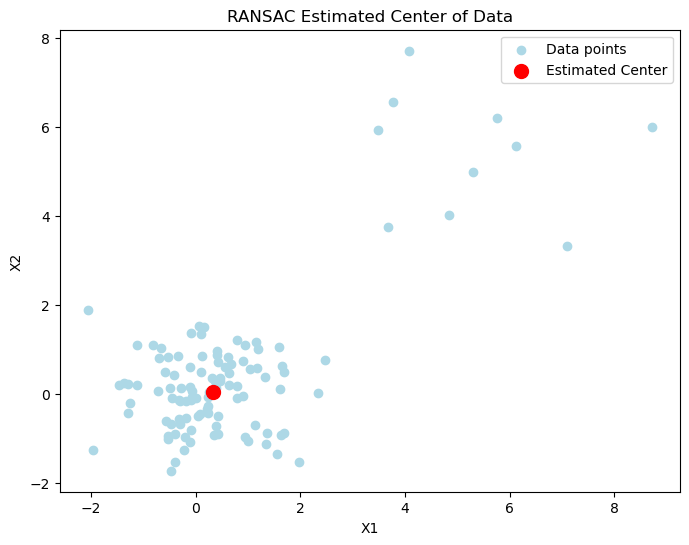

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.linear_model import RANSACRegressor

# Load MATLAB data file
matlab_data = scipy.io.loadmat('cloud-of-points-data.mat')

# Extract data points
X = matlab_data['X']
# print(X)  # Uncomment to view the data points

def ransac_center(X, n=50, k=100, t=1.0, d=0.5):
    n_points = len(X)  # Get the total number of points in the dataset
    best_center = None  # Variable to store the best estimated center
    best_inliers = 0  # Variable to store the maximum number of inliers found
    
    for _ in range(k):  # Run for a specified number of iterations (k)
        # Randomly select n points from the dataset
        maybe_inliers_idx = np.random.choice(n_points, n, replace=False)
        maybe_inliers = X[maybe_inliers_idx]  # Extract the selected points

        # Estimate the center as the mean of the selected points
        maybe_center = np.mean(maybe_inliers, axis=0)

        # Calculate the distance of all points to the estimated center
        distances = np.linalg.norm(X - maybe_center, axis=1)
        
        # Determine inliers as points within the specified distance threshold (t)
        inliers = X[distances < t]  # Points that are close to the estimated center

        # Update the best center if the current one has more inliers
        if len(inliers) > best_inliers:
            best_center = maybe_center
            best_inliers = len(inliers)

    return best_center  # Return the best estimated center

# Run the RANSAC algorithm to estimate the center of the data
center = ransac_center(X, n=50, k=100, t=0.5, d=0.5)
print(f"Estimated center of the data: {center}")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color='lightblue', label='Data points')  # Plot data points

# Highlight the estimated center with a red dot
plt.scatter(center[0], center[1], color='red', label='Estimated Center', s=100)

plt.xlabel('X1')  # Label for the x-axis
plt.ylabel('X2')  # Label for the y-axis
plt.legend()  # Display legend
plt.title('RANSAC Estimated Center of Data')  # Title of the plot
plt.show()  # Show the plot


Estimated centroids: [[1.83042216 1.94519198]
 [1.89098738 7.82011348]
 [8.12082704 8.02470105]]


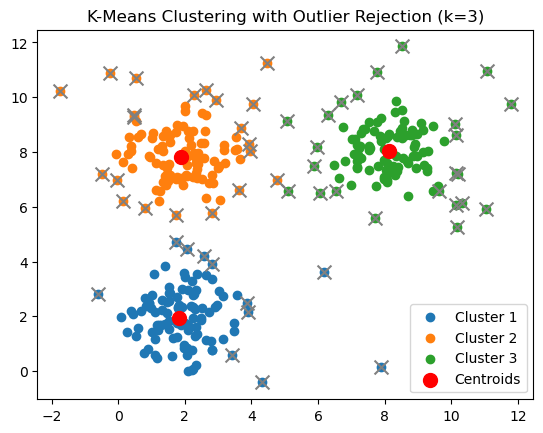

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# K-Means Clustering function with outlier rejection
def kmeans_clustering_with_outlier_rejection(X, k, max_iterations=100, tolerance=1e-4, outlier_threshold=2.0):
    n_points = X.shape[0]
    
    # Randomly initialize centroids
    centroids = X[np.random.choice(n_points, k, replace=False)]
    
    for _ in range(max_iterations):
        # Assign each point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate new centroids, ignoring outliers
        new_centroids = np.zeros((k, X.shape[1]))
        counts = np.zeros(k)

        for i in range(n_points):
            cluster_index = labels[i]
            distance_to_centroid = np.linalg.norm(X[i] - centroids[cluster_index])
            
            # Only include points within the outlier threshold
            if distance_to_centroid < outlier_threshold:
                new_centroids[cluster_index] += X[i]
                counts[cluster_index] += 1

        # Average the points to get the new centroid, avoiding division by zero
        for j in range(k):
            if counts[j] > 0:
                new_centroids[j] /= counts[j]
            else:
                new_centroids[j] = centroids[j]  # Keep the old centroid if no points are valid
        
        # Check for convergence (if centroids do not change significantly)
        if np.linalg.norm(new_centroids - centroids) < tolerance:
            break

        centroids = new_centroids
    
    return centroids, labels

# Example demonstration
def plot_clusters(X, centroids, labels, k, outlier_threshold):
    # Plot each cluster with a different color
    for i in range(k):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i + 1}')
    
    # Plot the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', s=100, label='Centroids')

    # Identify and plot outliers
    for i in range(X.shape[0]):
        if np.linalg.norm(X[i] - centroids[labels[i]]) >= outlier_threshold:
            plt.scatter(X[i, 0], X[i, 1], color='gray', marker='x', s=100)
    
    plt.title(f'K-Means Clustering with Outlier Rejection (k={k})')
    plt.legend()
    plt.show()

# Generate synthetic data with noise and outliers
def generate_noisy_cluster_data():
    np.random.seed(42)
    cluster_1 = np.random.randn(100, 2) + np.array([2, 2])
    cluster_2 = np.random.randn(100, 2) + np.array([8, 8])
    cluster_3 = np.random.randn(100, 2) + np.array([2, 8])
    
    # Add random noise (outliers)
    noise = np.random.uniform(low=-2, high=12, size=(20, 2))
    
    # Combine clusters and noise
    X = np.vstack([cluster_1, cluster_2, cluster_3, noise])
    
    return X

# Generate data
X = generate_noisy_cluster_data()

# Run K-Means clustering with outlier rejection
k = 3  # Number of clusters
centroids, labels = kmeans_clustering_with_outlier_rejection(X, k)

# Output the centroids and labels
print(f"Estimated centroids: {centroids}")

# Plot the resulting clusters
plot_clusters(X, centroids, labels, k, outlier_threshold=2.0)


In [ ]:
# c3

## Exercise 2 - [15%]

In Section 2.5 of the book "[The Elements of Statistical Learning: Data Mining, Inference, and Prediction](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12_toc.pdf)", by T. Hastie, R. Tibshirani, and J. Friedman, there is a mention about the effects of the *curse of dimensionality*. Read the section and implement the code to reproduce and verify all the experiments shown in the Figures 2.6, 2.7, 2.8, and 2.9.
	

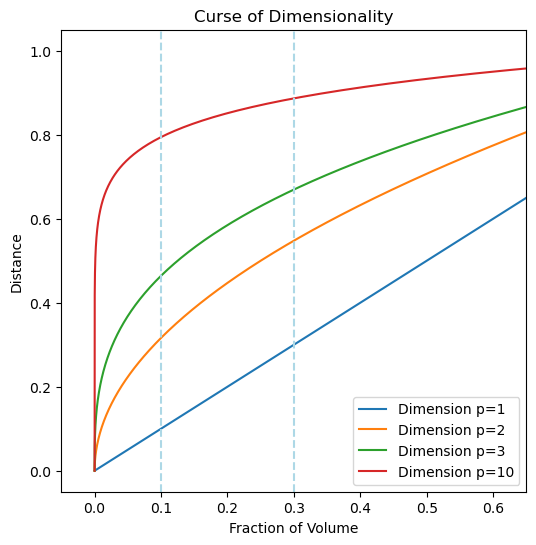

In [22]:
# figure 2.6
import numpy as np
import matplotlib.pyplot as plt

dimensions = [1, 2, 3, 10]

# Take 500 values from 0 to 1
edge_lengths = np.linspace(0, 1, 500)

plt.figure(figsize=(6, 6))
for d in dimensions:
    volume_ratios = edge_lengths ** d 
    plt.plot(volume_ratios, edge_lengths, label=f"Dimension p={d}")

plt.axvline(x=0.1, color='lightblue', linestyle='--')
plt.axvline(x=0.3, color='lightblue', linestyle='--')
plt.xlim(-0.05, 0.65)

plt.title("Curse of Dimensionality")
plt.xlabel("Fraction of Volume")
plt.ylabel("Distance")
plt.legend()
plt.grid(False)

plt.show()


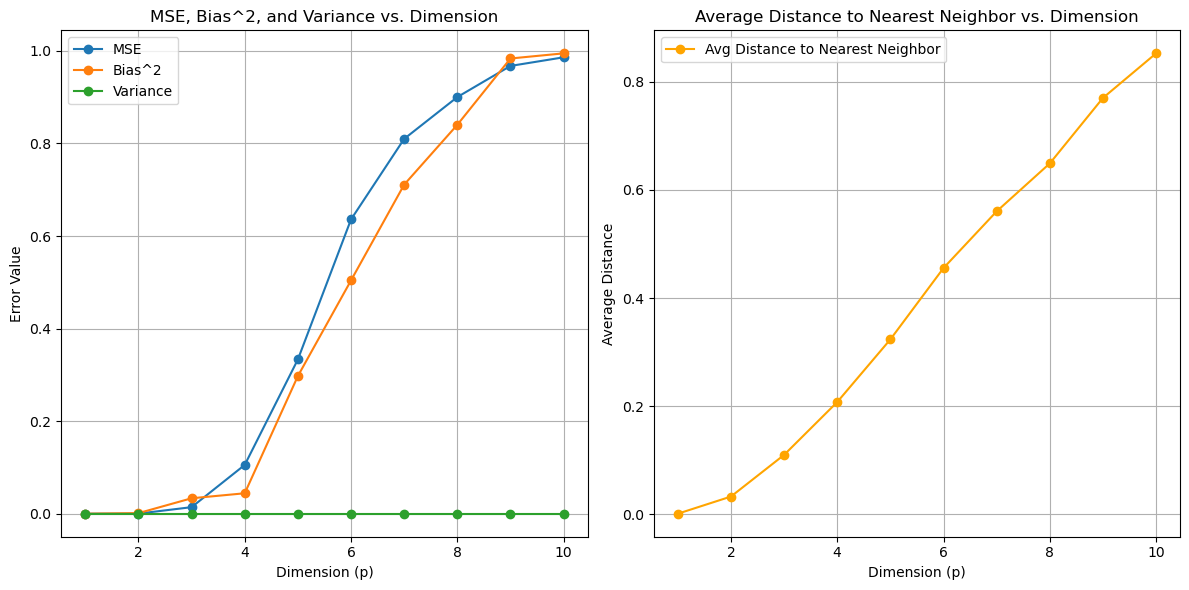

In [112]:
# figure 2.7
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Generate the data
np.random.seed(0)  # For reproducibility
num_samples = 1000
num_trials = 100  # Number of trials for averaging
mse_list = []
variance_list = []
bias_list = []
avg_distances = []  # List to store average distances

for p in range(1, 11):
    mse_trial = []
    distances = []  # List to store distances for the current dimension
    
    for _ in range(num_trials):
        # Generate training examples
        X_train = np.random.uniform(-1, 1, (num_samples, p))
        
        # Calculate Y using the function f(X) = e^(-8||X||^2)
        Y_train = np.exp(-8 * np.linalg.norm(X_train, axis=1) ** 2)

        # Train the 1-Nearest Neighbor model
        knn = KNeighborsRegressor(n_neighbors=1)
        knn.fit(X_train, Y_train)

        # Predict the value at the test point x_0 = 0
        x_0 = np.zeros((1, p))  # x_0 is a 1x2 array for p=2
        y_0_pred = knn.predict(x_0)[0]
        
        # True value at x_0
        y_0_true = np.exp(-8 * np.linalg.norm(x_0)**2)

        # Calculate MSE for this trial
        mse_trial.append((y_0_pred - y_0_true) ** 2)

        # Find the distance to the nearest neighbor
        distances_to_neighbors = knn.kneighbors(x_0, return_distance=True)
        neighbor_distance = distances_to_neighbors[0][0][0]  # Get the distance to the nearest neighbor
        distances.append(neighbor_distance)

    # Calculate mean MSE and average distance for this dimension
    mean_mse = np.mean(mse_trial)
    mse_list.append(mean_mse)

    # Calculate variance and bias
    bias = y_0_true - np.mean([knn.predict(np.zeros((1, p)))[0] for _ in range(num_trials)]) 
    variance = np.var([knn.predict(np.zeros((1, p)))[0] for _ in range(num_trials)])

    bias_list.append(bias**2)  # Bias squared
    variance_list.append(variance)

    # Calculate average distance to the nearest neighbor
    avg_distance = np.mean(distances)
    avg_distances.append(avg_distance)

# Plot the results
plt.figure(figsize=(6, 6))

# MSE, Bias^2, and Variance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), mse_list, label='MSE', marker='o')
plt.plot(range(1, 11), bias_list, label='Bias^2', marker='o')
plt.plot(range(1, 11), variance_list, label='Variance', marker='o')
plt.title('MSE, Bias^2, and Variance vs. Dimension')
plt.xlabel('Dimension (p)')
plt.ylabel('Error Value')
plt.legend()
plt.grid(False)

# Average distance to the nearest neighbor plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), avg_distances, label='Avg Distance to Nearest Neighbor', marker='o', color='orange')
plt.title('Average Distance to Nearest Neighbor vs. Dimension')
plt.xlabel('Dimension (p)')
plt.ylabel('Average Distance')
plt.legend(False)
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
#  2.8, 2.9

## Exercise 3 - [15%]

**a)** The rule of thumb for **train/test split** ratio is to choose it to be quite larger than 1 (e.g a 75%-25% train/test split). Validate empirically this choice:

* Choose a dataset for a classification task.
* Use a classification method that is suitable for the problem (i.e. performs reasonably well on the dataset).
* Try several train/test split ratio values (e.g. 0% to 100% with step 5%).
* Use plot(s) to display the performance of the method on the test set in each case.
* Justify in detail the observed behavior using arguments founded in the theory (see bias-variance trade off).
* What is (approx.) the best choice of ratio in your case?
* Now, using a train/validation/test split, optimize the hyperparameters of your model, and give the final trained model that you would deliver for practical use. 


- We use the Iris dataset in Scikit Learn, to classify them, we call the `RandomForestClassifier` function, which is an easy way to implement. This is efficient because Iris is a small dataset and the random forest algorithm is based on decision trees, which are inherently good at capturing non-linear relationships between the input features and the target. The combination of multiple decision trees, each trained on random subsets of the data and features, results in a model with high predictive accuracy.

"https://en.wikipedia.org/wiki/Random_forest"

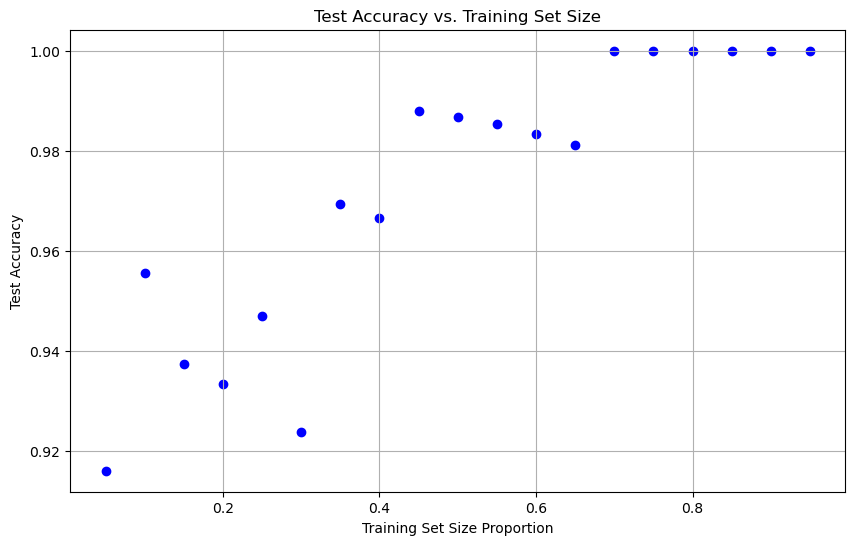

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score 

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target  # Separate features and target labels

# Define the range of training set sizes to test
train_sizes = np.arange(0.05, 1.0, 0.05)  # Training set sizes from 5% to 95%
test_accuracies = []  # List to store accuracy results for each training size

# Loop over different training sizes
for train_size in train_sizes:
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # Initialize the Random Forest Classifier
    clf = RandomForestClassifier(random_state=42)
    # Fit the model to the training data
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    # Calculate and store the accuracy of the model
    test_accuracies.append(accuracy_score(y_test, y_pred))

# Plot the test accuracy against the proportion of the training set size
plt.figure(figsize=(10, 6))
plt.scatter(train_sizes, test_accuracies, marker='o', color='b')  # Plot accuracy points
plt.title('Test Accuracy vs. Training Set Size')  # Title of the plot
plt.xlabel('Training Set Size Proportion')  # Label for the x-axis
plt.ylabel('Test Accuracy')  # Label for the y-axis
plt.grid(True)  # Add grid lines to the plot
plt.show()  # Display the plot


- We can observe that the best training ratio is about 70%, at this value the accuracy is already 100%. Then we keep this training ratio for the next train/validation/test split.

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score 

# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target  # Separate features and target labels

# Set the train/validation/test split 
train_size = 0.7
validation_size = 0.15
test_size = 0.15

# First, perform a train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=42)

# Then, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Perform grid search for hyperparameter optimization using cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit grid search on the training data

# Print the best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Predict using the best model on the validation set
y_val_pred = best_model.predict(X_val)

# Calculate and print the validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Now predict using the best model on the test set
y_test_pred = best_model.predict(X_test)

# Calculate and print the final test accuracy
final_accuracy = accuracy_score(y_test, y_test_pred)
print("Final Test Accuracy:", final_accuracy)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy: 1.0
Final Test Accuracy: 1.0


## Exercise 3 - [15%]

**b)** *Cross-validation* splits the set of data in non-overlapping parts, then learns and tests the performance of a method independently in the different parts of the data, e.g. i) train-test set split, or ii) k-folded approach. 

Imagine that you have to apply (i) and (ii) for validating a regression method for time-series, a task which is also referred as *time-series forecasting*. Note that in this case the element of time should be respected.

Describe a procedure, by giving a pseudocode, that would apply (i) and (ii).



In [ ]:
# Pseudocode

# train-test set split
def train_test_split_time_series(data, train_size):
    n_train = int(len(data) * train_size)
    train_data = data[:n_train]
    test_data = data[n_train:]
    return train_data, test_data

# k-folded approach
def time_series_cv(data, n_splits):
    n = len(data)
    step = n // n_splits
    for i in range(1, n_splits + 1):
        train_data = data[:i * step]
        test_data = data[i * step:(i + 1) * step]
        yield train_data, test_data


## Exercise 4 - [20%]

The purpose of this exercise is to apply classification for two data classes using a **simple linear model**. However, the particularity is that we are in the context of *stream processing* where data arrive sequentially in pairs of observations, containing one observation from each class, i.e. each time $t$ we observe $(x_t \in \text{class A}, x'_t \in \text{class B})$. As *we cannot store all the data* to apply batch processing, we need to develop a frugal online learning approach that would require as little as possible stored information at each time $t$ for a simple linear model $model_t$, which then would be updated based on the incoming $(x_t, x'_t)$'s. At any time $t$ the model $model_t$ should be able to classify uknown data.

**a)** Analyze in detail the requirements of this problem setting, and implement an approach to produce a linear model for all the data of the stream. Explain why it is correct and how much memory resources it would need to run.

**b)** To train your model consider $N = n+n$ data produced two 2D Gaussian distributions ($n$ instances from each of them) that have (e.g.) same standard deviation and different mean values $\mu_1$ and $\mu_2$. Use a large $N$ (e.g. $500$) and show the performance of $model_t$ at the course of time (i.e. for $t=1,...,N$) using a test-set of $500 + 500$ datapoints generated from the same distributions. Compare in the same plot (e.g. it would appear as fixed horizontal line) against a linear classifier that is trained directly on the $N$ datapoints. Use a couple of $\mu_1$ and $\mu_2$ pairs to show an easy case and a more difficult one.


#### 1. **Online Learning with Minimal Data Storage**:
   - The key aspect of the exercise is that we are dealing with **stream processing**, where data arrives sequentially in pairs from two classes, and we cannot store all the data.
   - In the `online_learning()` function, the data is processed in **batches of size 2**, which corresponds to receiving one observation from **class A** and one from **class B** at each time step.
   - The use of `partial_fit()` in `SGDClassifier` allows the model to be updated **incrementally** as new data arrives, without requiring access to the entire dataset. This means we are only storing **two observations at a time**, satisfying the requirement for **frugal memory usage**.
   
#### 2. **Simple Linear Model**:
   - The `SGDClassifier` is used with the **hinge loss function**, which is equivalent to an **SVM-like linear classifier**. This ensures that the model remains **simple and linear** as required by the exercise.
   - The linear classifier only needs to store a small number of parameters (the weights and the intercept) corresponding to the decision boundary in 2D space. The model’s memory footprint is thus minimal, as the complexity of the model is low.

#### 3. **Sequential Data Updates**:
   - At each time step `t`, the model is updated based on the incoming pair of observations `(x_t, x'_t)` from both classes. This ensures that the model is learning in a **sequential, online manner**, directly in line with the problem's constraints.
   - The data is not stored in memory after each update, only the model parameters are retained and updated, which keeps the resource usage low and suitable for stream processing.

#### 4. **Real-time Classification**:
   - At any time `t`, after receiving a pair of observations and updating the model, the model is ready to classify new, unseen data. This ensures that the requirement for the model to be **always ready to classify unknown data** is met.
   - The accuracy of the model is tested on a separate test set after each batch update in the `online_learning()` function, demonstrating its ability to handle real-time classification.

#### 5. **Frugal Memory Usage**:
   - The model only stores the **current model parameters** and **two observations** at each time step. This satisfies the condition of using as little stored information as possible while still effectively training a simple linear classifier.
   - By processing data in pairs and updating the model with `partial_fit()`, there is no need for batch storage or processing, making the approach well-suited for **stream processing** with limited memory.


####  **Memory Resource Usage**:

##### a. **Data Size**:
   - Each dataset consists of **2n samples (1000 samples in total)**, with each sample having **2 features**. Since the data is stored as NumPy arrays, the memory needed for the dataset can be calculated as:
     - For `X_easy` or `X_hard`: $ 1000 \text{ samples} \times 2 \text{ features} \times 8 \text{ bytes per float} = 16 \text{ KB} $.
     - For `y_easy` or `y_hard`: $ 1000 \text{ labels} \times 8 \text{ bytes per float} = 8 \text{ KB} $.
   
   So, each dataset (features + labels) requires around **24 KB** of memory.

##### b. **SGDClassifier**:
   - The `SGDClassifier` is a relatively lightweight model in terms of memory usage. It stores coefficients for a linear decision boundary, which in this case corresponds to **2 coefficients (one for each feature)**, and potentially an **intercept** term. The model's memory footprint is small, scaling with the number of features.
   - In online learning, the model is updated iteratively, so it doesn't store the entire dataset in memory at once. It processes batches of 2 samples at a time, meaning only **16 bytes** (for the batch features) and **16 bytes** (for the labels) are temporarily stored during training.

##### c. **Overall Memory Estimate**:
   - The total memory required is modest:
     - Datasets: ~48 KB (for both easy and hard cases).
     - SGDClassifier model weights: ~24 bytes for the coefficients and intercept.
     - Temporary memory for batches: ~32 bytes.
   
   **Total Memory Estimate**: Approximately **50 KB** (excluding overhead from Python structures).

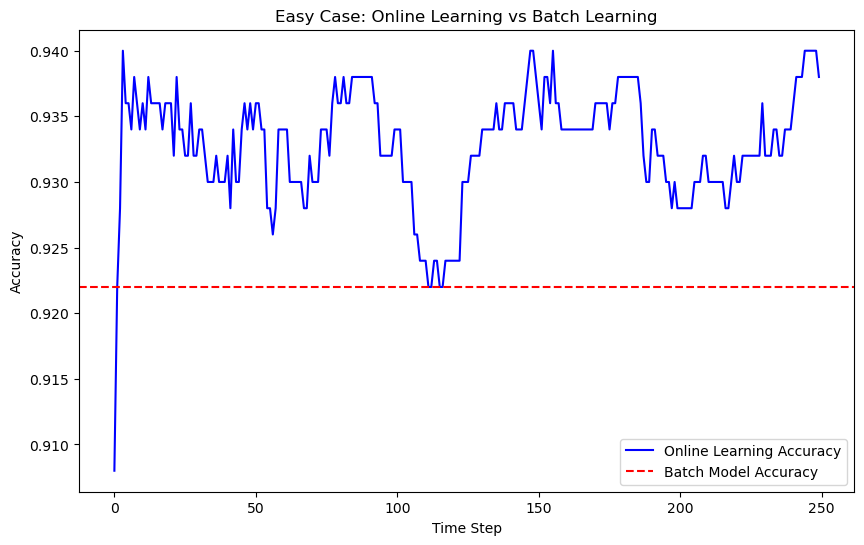

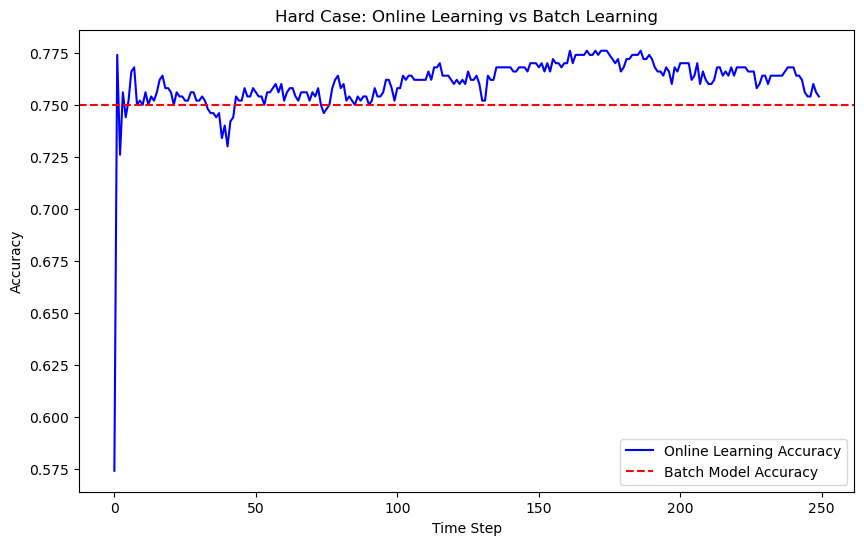

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Function to generate synthetic data for two classes
def generate_data(n, mu1, mu2, sigma=1.0, random_state=None):
    np.random.seed(random_state)  # Set the random seed for reproducibility
    
    # Generate n samples from a multivariate normal distribution for class A
    X_classA = np.random.multivariate_normal(mu1, sigma*np.eye(2), n)
    # Generate n samples from a multivariate normal distribution for class B
    X_classB = np.random.multivariate_normal(mu2, sigma*np.eye(2), n)
    
    # Create labels for the two classes
    y_classA = np.ones(n)  # Class A labeled as 1
    y_classB = np.zeros(n)  # Class B labeled as 0
    
    # Stack the samples vertically and labels horizontally to create the final dataset
    X = np.vstack((X_classA, X_classB))
    y = np.hstack((y_classA, y_classB))
    
    return X, y  # Return the generated dataset and labels

# Parameters for data generation
n = 500  # Number of samples per class
mu1_easy = [1, 1]  # Mean for class A in easy case
mu2_easy = [-1, -1]  # Mean for class B in easy case
mu1_hard = [0.5, 0.5]  # Mean for class A in hard case
mu2_hard = [-0.5, -0.5]  # Mean for class B in hard case
sigma = 1.0  # Standard deviation for both classes
random_state = 42  # Random seed for reproducibility

# Generate easy case data
X_easy, y_easy = generate_data(n, mu1_easy, mu2_easy, sigma, random_state)
# Split the easy case data into training and testing sets
X_easy_train, X_easy_test, y_easy_train, y_easy_test = train_test_split(X_easy, y_easy, test_size=0.5, random_state=random_state)

# Generate hard case data
X_hard, y_hard = generate_data(n, mu1_hard, mu2_hard, sigma, random_state)
# Split the hard case data into training and testing sets
X_hard_train, X_hard_test, y_hard_train, y_hard_test = train_test_split(X_hard, y_hard, test_size=0.5, random_state=random_state)

# Function to implement online learning using Stochastic Gradient Descent (SGD)
def online_learning(X_train, y_train, X_test, y_test, max_iter=500):
    # Initialize the SGD classifier with hinge loss (for SVM-like behavior)
    sgd = SGDClassifier(loss="hinge", max_iter=1, learning_rate='constant', eta0=0.01, random_state=42, warm_start=True)

    # List to store accuracies over time
    accuracies = []

    # Iterate through the training data in batches of size 2
    for i in range(0, len(X_train), 2):
        X_batch = X_train[i:i+2]  # Get the current batch of training data
        y_batch = y_train[i:i+2]  # Get the corresponding labels
        
        if i == 0:
            # Fit the model for the first batch and specify the classes
            sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        else:
            # Fit the model for subsequent batches without re-specifying classes
            sgd.partial_fit(X_batch, y_batch)
        
        # Predict on the test set and calculate accuracy
        y_pred = sgd.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)  # Append the accuracy to the list

    return accuracies, sgd  # Return the list of accuracies and the trained model

# Function to train a batch model and evaluate its accuracy
def batch_model(X_train, y_train, X_test, y_test):
    # Initialize the SGD classifier for batch learning
    sgd = SGDClassifier(loss="hinge", max_iter=500, random_state=42)
    sgd.fit(X_train, y_train)  # Train the model on the entire training set
    
    y_pred = sgd.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    
    return accuracy  # Return the accuracy of the batch model

# Function to plot the results of online learning versus batch learning
def plot_results(accuracies_online, accuracy_batch, title):
    plt.figure(figsize=(10, 6))  # Create a new figure for the plot
    plt.plot(accuracies_online, label="Online Learning Accuracy", color='b')  # Plot online learning accuracies
    plt.axhline(y=accuracy_batch, color='r', linestyle='--', label="Batch Model Accuracy")  # Plot batch model accuracy as a horizontal line
    plt.xlabel('Time Step')  # Label for the x-axis
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.title(title)  # Set the title of the plot
    plt.legend()  # Show legend
    plt.show()  # Display the plot

# Run online learning on the easy case
accuracies_online_easy, _ = online_learning(X_easy_train, y_easy_train, X_easy_test, y_easy_test)
# Evaluate the batch model for the easy case
accuracy_batch_easy = batch_model(X_easy_train, y_easy_train, X_easy_test, y_easy_test)
# Plot the results for the easy case
plot_results(accuracies_online_easy, accuracy_batch_easy, "Easy Case: Online Learning vs Batch Learning")

# Run online learning on the hard case
accuracies_online_hard, _ = online_learning(X_hard_train, y_hard_train, X_hard_test, y_hard_test)
# Evaluate the batch model for the hard case
accuracy_batch_hard = batch_model(X_hard_train, y_hard_train, X_hard_test, y_hard_test)
# Plot the results for the hard case
plot_results(accuracies_online_hard, accuracy_batch_hard, "Hard Case: Online Learning vs Batch Learning")


## Exercise 5 - [10%]

Relying on the central hypothesis that a learning problem should enjoy regularity along the domain of the data (see [Lab 1](http://kalogeratos.com/MyCourses/DML-M2HPC/Lab1.ipynb)), we would like to define a heuristic data-driven measure to evaluate a given model.

More specifically, consider a classification problem and define a regularity measure based on the nearest neighbors principle that can assess how regular the decisions of a given classifier is. Explain the logic of your proposition. Let's call this function **Regularity(X, Y, +any needed parameters)**.

**Recipe for testing**

In this exercise you have to generated data from a mixture of 2 Gaussian distributions, and then measure the effect of your Regularity measure and the standard Accuracy with regards to the following factors:

* the size of the dataset; try generating classes of same standard deviation $\sigma = 2$ and equal size, where each of them will have $n_i\in\{50, 100, 200, 500\}$ objects;
* the dimensionality $d$ of the data; try $d\in\{1,2,3,...\,,10, 20, 30,...\,100\}$;
* the overlap of the classes $\delta$ in the feature space, i.e. the distance between the classes; try $\delta\in\{\sigma, 2\sigma, 3\sigma, 4\sigma\}$;
* the input parameter $k$ which indirectly adjusts how far from an object the classifier will seek for `advices' from other objects in order to classify it; try $k\in\{1,...\,,10\}$.

**Sample pseudocode:**  

for each tuple <$n$, $d$, $\delta$, $k$>
   * generate data  
   * compute average quality over $10$ runs of the following  
       * train a $k$NN classifier and a decision tree (choose nicely the depth)   
       * test the classifiers using Accuracy and Regularity  

end for

The evaluation should be performed with and without 10-fold CV (inside the train/test nested part). Use at least the suggested value range for each parameter, but you can extend it if this way you capture some interesting behavior. 

**Questions:** 
- What is the main difference between a $k$NN and a radius-NN classifier? In which case(s) one is better to the other? How would we have to adapt the above discussion if radius-NN classifier is used instead of the standard $k$NN?
- What would change if we were interested in measuring the Regularity in the context of a regression problem?

##### Differences:
- The NN classifier (commonly referred to as k-NN with k=1) classifies a data point based on the label of its **nearest neighbor** in the feature space. It identifies the single closest training example and assigns its label to the test instance. The radius-NN classifier classifies a data point based on all training examples that are within a specified **radius** from the test point. It counts the labels of all points in this neighborhood and assigns the label that appears most frequently (or a weighted vote based on distance).

- **NN Classifier** assigns the class label of the single nearest neighbor, leading to a more **discrete** decision boundary. **Radius-NN Classifier** uses multiple neighbors within a defined radius, which results in a potentially **smoother** decision boundary since it aggregates information from several points, not just one.

- **NN Classifier** is more sensitive to noise and outliers because it bases its classification solely on the nearest point, which could be an outlier. **Radius-NN Classifier** is more robust to noise since it considers multiple neighbors. If an outlier is present, it may be excluded if it falls outside the specified radius.

- **NN Classifier** is better when the dataset is small and well-separated, where the nearest point is likely to provide a reliable classification. It's a fast, simple classification method with minimal parameters. **Radius-NN Classifier** is better when the data is noisy, and robustness is needed against outliers, or the data distribution is irregular, as it can leverage the density of points within the radius, or if we need to incorporate more context by considering several neighbors in classification.

#### Adaptations Needed if Using Radius-NN Instead of Standard NN

##### 1. **Parameter Specification**:
- When using a radius-NN classifier, a **radius parameter** must be specified. This parameter defines how far from the test point you will look for neighbors. In the original NN approach, this parameter is implicit (the closest neighbor).

##### 2. **Data Processing**:
- The online learning approach discussed earlier would need to incorporate logic to maintain the list of neighbors within the specified radius instead of just the closest point.
- You would need to update the classification logic to count votes from all neighbors within the defined radius rather than simply choosing the nearest neighbor.

##### 3. **Memory Management**:
- The memory requirements may vary. In radius-NN, you need to store all points within the radius for classification, which can potentially increase memory usage, especially in dense regions. Careful management may be needed to limit the radius or the number of points considered.

##### 4. **Accuracy Evaluation**:
- Accuracy evaluation may need to account for the number of points considered. In cases where the radius includes varying numbers of neighbors, the voting mechanism may need to be adjusted (e.g., weighted voting based on distance).

##### 5. **Model Interpretation**:
- With radius-NN, the interpretability of results could change, as the classifier is now aggregating information from potentially multiple points rather than relying on a single nearest point. This aggregation may provide a more nuanced understanding of classifications, particularly in dense data areas.

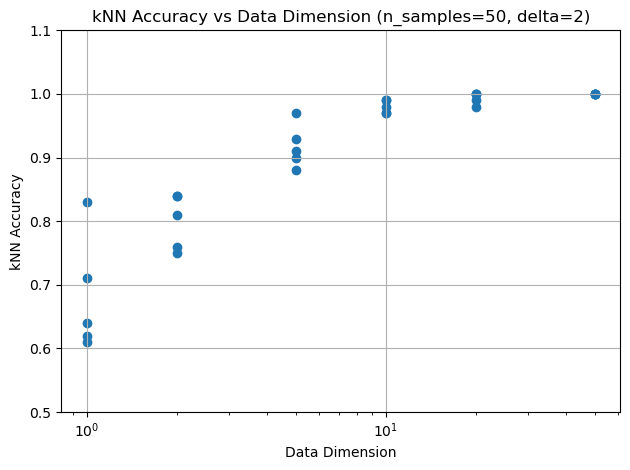

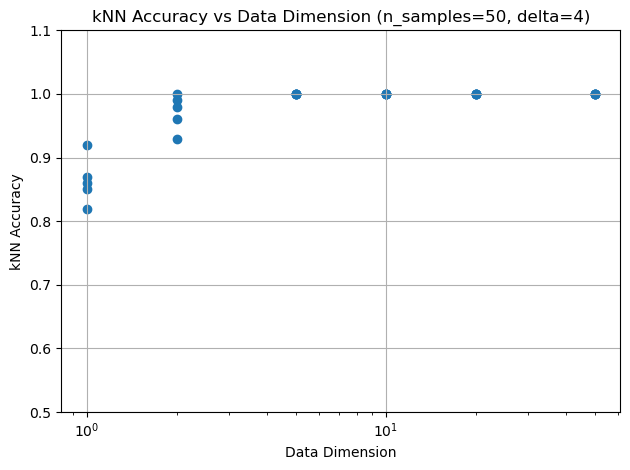

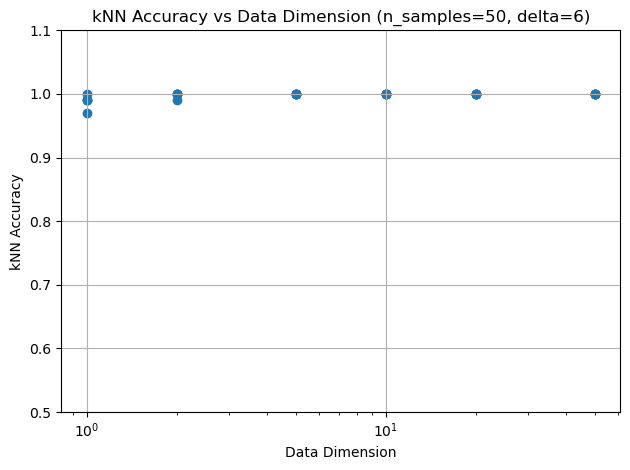

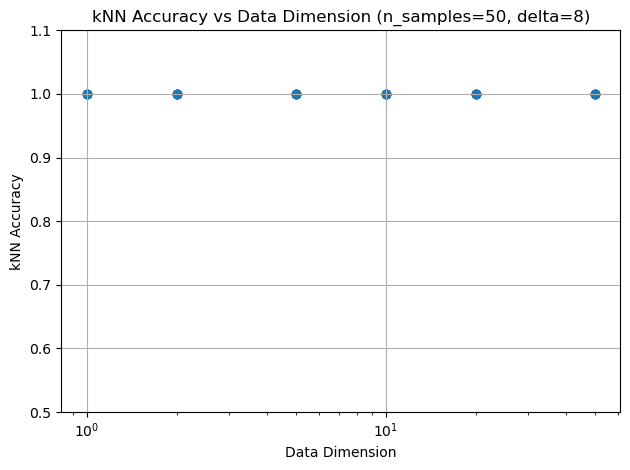

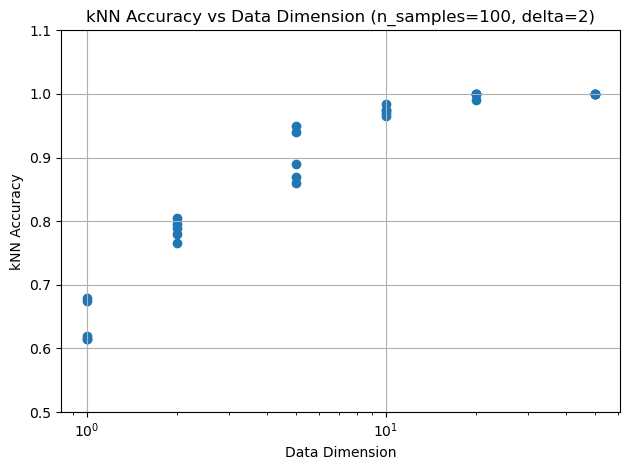

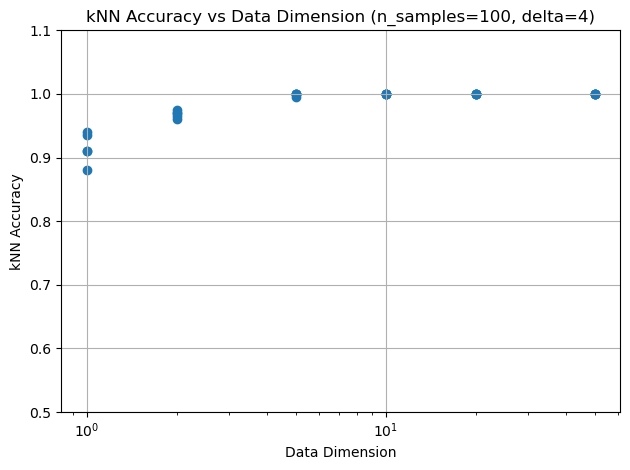

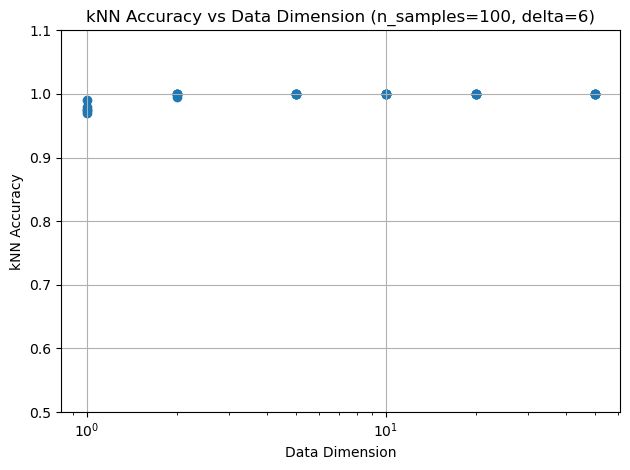

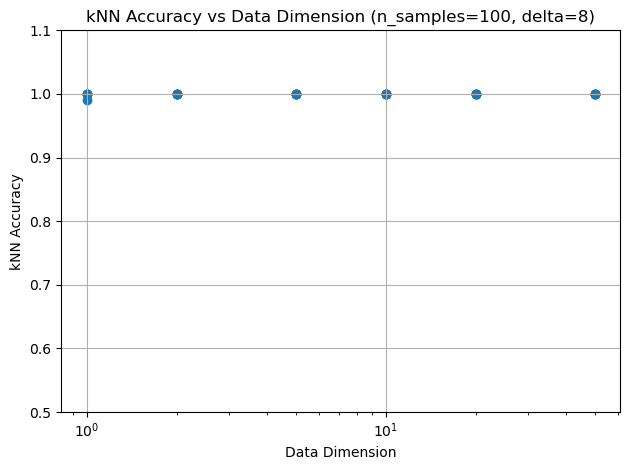

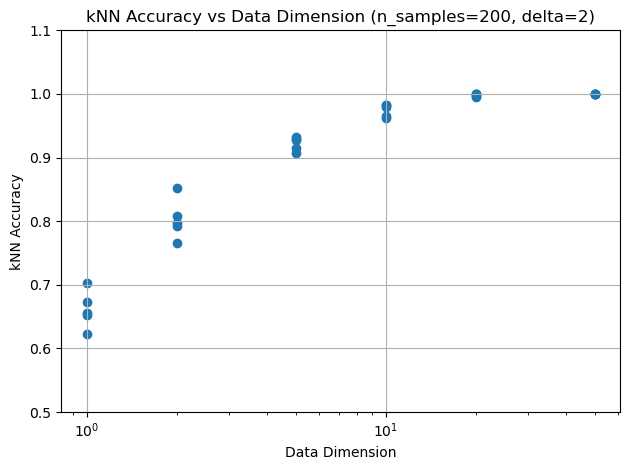

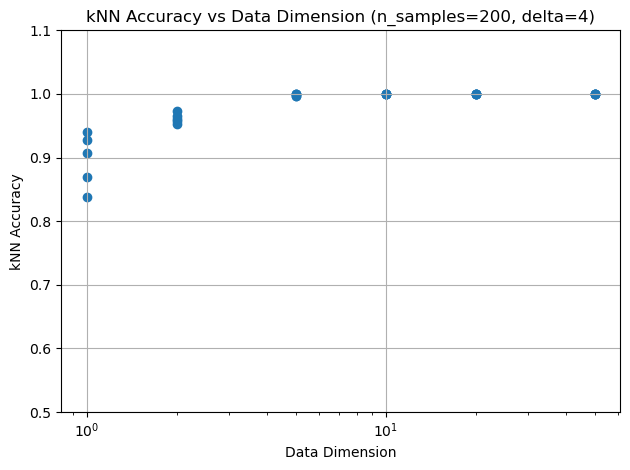

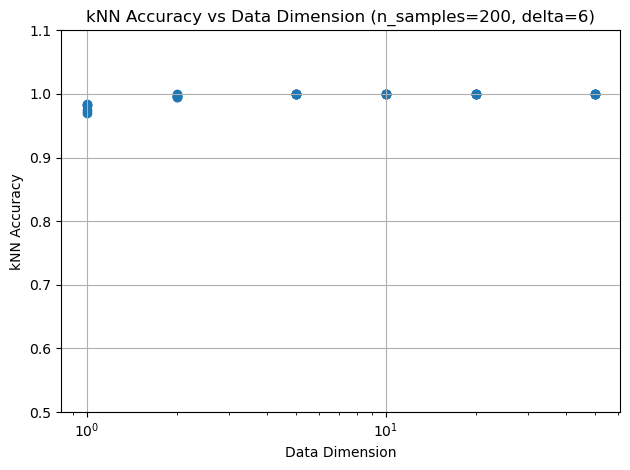

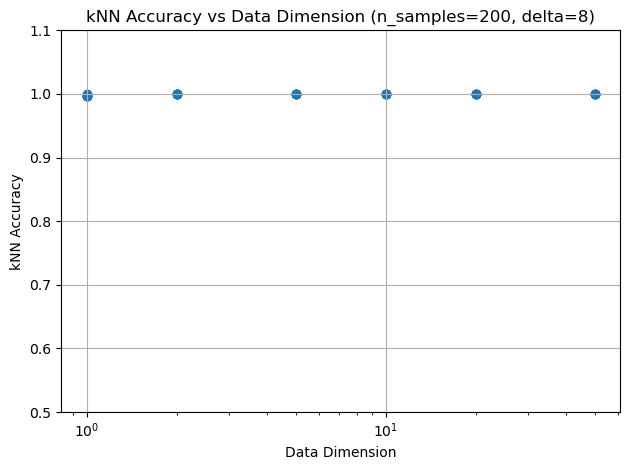

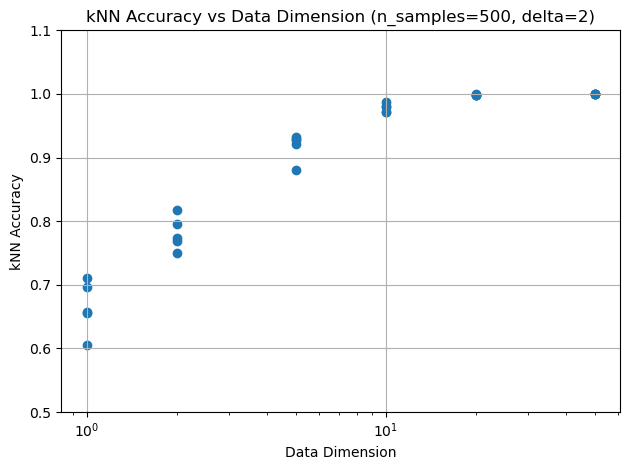

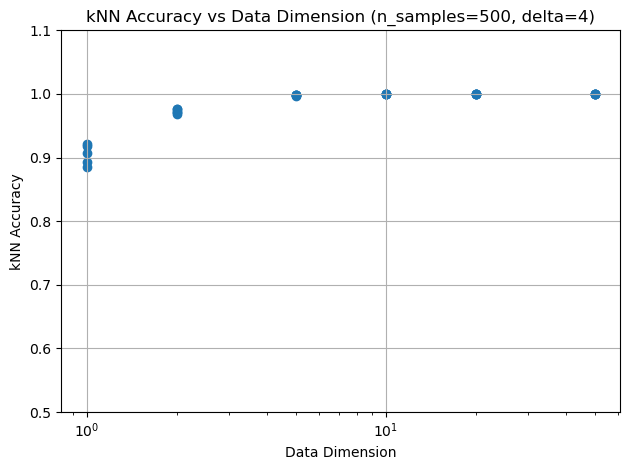

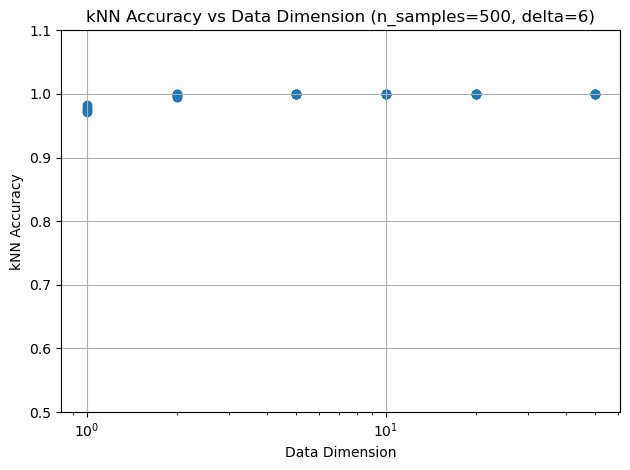

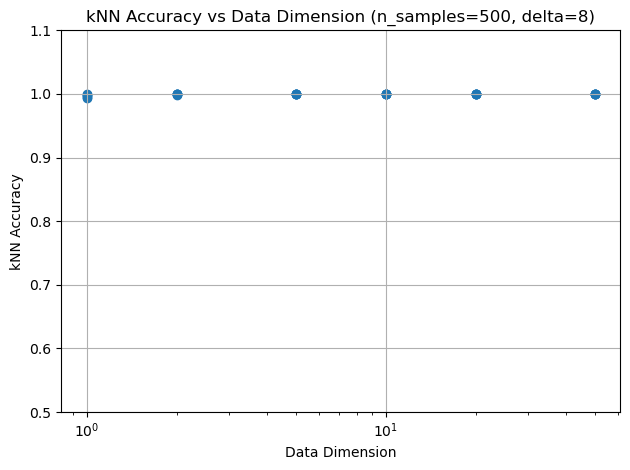

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Define Regularity Score function
def regularity_score(X, Y, k=5):
    """
    Compute regularity using nearest neighbors.
    For each point, find its k nearest neighbors and check the proportion of neighbors
    that share the same label as the point.
    """
    n_samples = X.shape[0]  # Get the number of samples
    distances = cdist(X, X)  # Compute pairwise distance matrix between samples
    np.fill_diagonal(distances, np.inf)  # Set self-distance to infinity to avoid self-neighbors

    correct_neighbors = 0  # Initialize counter for correct neighbors
    for i in range(n_samples):
        # Find the k nearest neighbors for each point
        neighbors_idx = np.argsort(distances[i])[:k]
        # Check if neighbors' labels are the same as the point's label
        correct_neighbors += np.sum(Y[neighbors_idx] == Y[i])
    
    # Return the proportion of correct neighbors as the regularity score
    return correct_neighbors / (n_samples * k)

# Data generation function
def generate_data(n_samples, n_features, delta):
    """
    Generate classification data with two Gaussian distributions.
    n_samples: Number of data points per class
    n_features: Dimensionality of the data
    delta: Distance between the two class means
    """
    mean_A = np.zeros(n_features)  # Mean for class A
    mean_B = np.ones(n_features) * delta  # Mean for class B, shifted by delta
    cov = np.identity(n_features) * 2  # Covariance matrix with variance 2

    # Generate samples for class A and class B
    X_A = np.random.multivariate_normal(mean_A, cov, n_samples)
    X_B = np.random.multivariate_normal(mean_B, cov, n_samples)
    Y_A = np.zeros(n_samples)  # Labels for class A
    Y_B = np.ones(n_samples)  # Labels for class B

    # Stack the samples vertically and labels horizontally to create the final dataset
    X = np.vstack((X_A, X_B))
    Y = np.hstack((Y_A, Y_B))

    return X, Y  # Return the generated dataset and labels

# Model training and evaluation function
def evaluate_classifiers(X_train, X_test, Y_train, Y_test, k, max_depth):
    """
    Train kNN and Decision Tree classifiers and evaluate their accuracy and regularity.
    """
    # kNN Classifier
    knn = KNeighborsClassifier(n_neighbors=k)  # Initialize kNN classifier
    knn.fit(X_train, Y_train)  # Fit the model on training data
    knn_pred = knn.predict(X_test)  # Make predictions on test data
    knn_accuracy = accuracy_score(Y_test, knn_pred)  # Calculate accuracy for kNN
    knn_regularity = regularity_score(X_test, knn_pred, k=k)  # Calculate regularity for kNN

    # Decision Tree Classifier
    tree = DecisionTreeClassifier(max_depth=max_depth)  # Initialize Decision Tree
    tree.fit(X_train, Y_train)  # Fit the model on training data
    tree_pred = tree.predict(X_test)  # Make predictions on test data
    tree_accuracy = accuracy_score(Y_test, tree_pred)  # Calculate accuracy for Decision Tree
    tree_regularity = regularity_score(X_test, tree_pred, k=k)  # Calculate regularity for Decision Tree

    return knn_accuracy, knn_regularity, tree_accuracy, tree_regularity  # Return accuracy and regularity for both classifiers

# Parameter search and evaluation
def parameter_search(n_samples_list, d_list, delta_list, k_list):
    """
    Perform parameter search over given sample sizes, dimensions, deltas, and k values.
    """
    results = []  # Initialize a list to store results
    for n_samples in n_samples_list:  # Iterate over number of samples
        for d in d_list:  # Iterate over dimensions
            for delta in delta_list:  # Iterate over delta values
                for k in k_list:  # Iterate over k values
                    # Generate data
                    X, Y = generate_data(n_samples, d, delta)

                    # 10-fold cross-validation
                    kf = KFold(n_splits=10)  # Initialize KFold cross-validator
                    knn_accuracies, knn_regularities = [], []  # Initialize lists for kNN results
                    tree_accuracies, tree_regularities = [], []  # Initialize lists for Decision Tree results

                    # Perform cross-validation
                    for train_idx, test_idx in kf.split(X):
                        X_train, X_test = X[train_idx], X[test_idx]  # Split the data into train and test sets
                        Y_train, Y_test = Y[train_idx], Y[test_idx]  # Split the labels accordingly

                        # Evaluate kNN and Decision Tree classifiers
                        knn_acc, knn_reg, tree_acc, tree_reg = evaluate_classifiers(
                            X_train, X_test, Y_train, Y_test, k=k, max_depth=5)
                        
                        # Append results to the lists
                        knn_accuracies.append(knn_acc)
                        knn_regularities.append(knn_reg)
                        tree_accuracies.append(tree_acc)
                        tree_regularities.append(tree_reg)

                    # Record the average results
                    results.append({
                        'n_samples': n_samples,
                        'dim': d,
                        'delta': delta,
                        'k': k,
                        'knn_accuracy': np.mean(knn_accuracies),
                        'knn_regularity': np.mean(knn_regularities),
                        'tree_accuracy': np.mean(tree_accuracies),
                        'tree_regularity': np.mean(tree_regularities)
                    })

    return results  # Return the collected results

# Perform the parameter search
results = parameter_search(n_samples_list, d_list, delta_list, k_list)

# Visualize results: Create a plot for each combination of n_samples and delta
for n_samples in n_samples_list:
    for delta in delta_list:
        dims = [result['dim'] for result in results if result['n_samples'] == n_samples and result['delta'] == delta]
        knn_accuracies = [result['knn_accuracy'] for result in results if result['n_samples'] == n_samples and result['delta'] == delta]

        plt.figure()  # Create a new figure for the plot
        plt.scatter(dims, knn_accuracies, marker='o')  # Plot the kNN accuracies against dimensions
        plt.title(f'kNN Accuracy vs Data Dimension (n_samples={n_samples}, delta={delta})')  # Set the title
        plt.xlabel('Data Dimension')  # Set x-axis label
        plt.xscale('log')
        plt.ylabel('kNN Accuracy')  # Set y-axis label
        plt.grid(True)  # Enable grid
        plt.ylim(0.5, 1.1)  # Set y-axis limits for accuracy
        plt.tight_layout()  # Adjust layout to fit
        plt.show()  # Display the plot


## Exercise 6 - [10%]

Apply ridge regression and lasso regression on the diabetes dataset. Use all the features but the 11th as input parameters, and the 11th as target (it's an index showing the progression of the disease). 
* Search for a good $a$ regularization penalty using Cross Validation (use built-in functions of scikit-learn) for each method, as in the examples 4 and 5 of Lab 2. 
* Generate plots that show the evolution of all the coefficients (the elements of the $w$ vector) and -in a second plot- regression scores such as the residuals and the [$R^2$ measure](https://en.wikipedia.org/wiki/Coefficient_of_determination) showing how well the model fits to the data.
* Discuss your comparative findings.

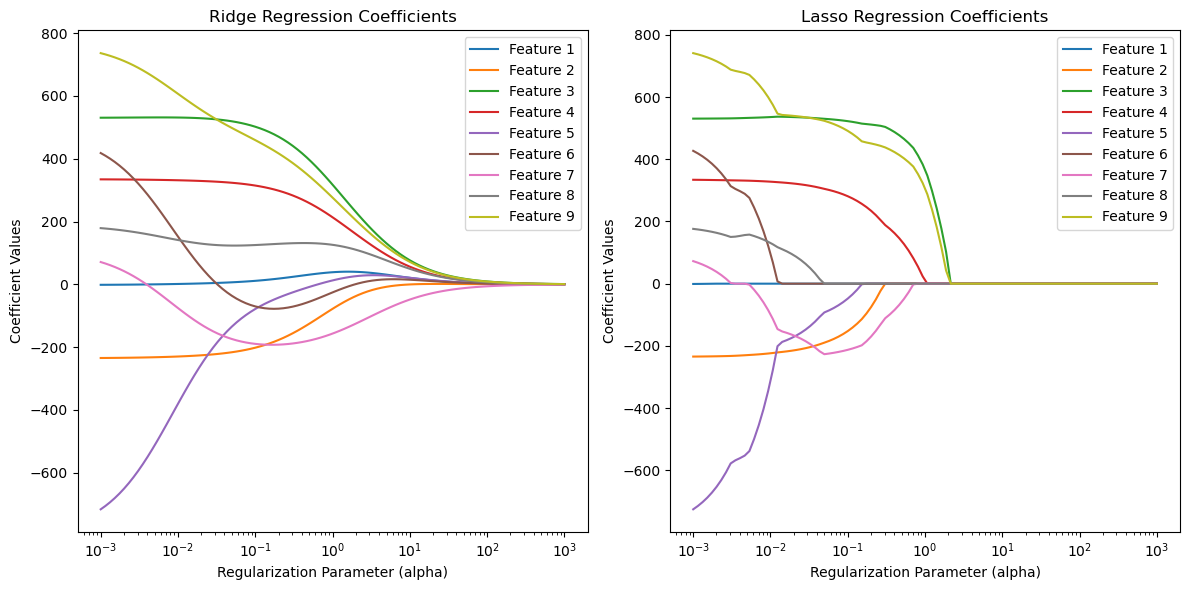

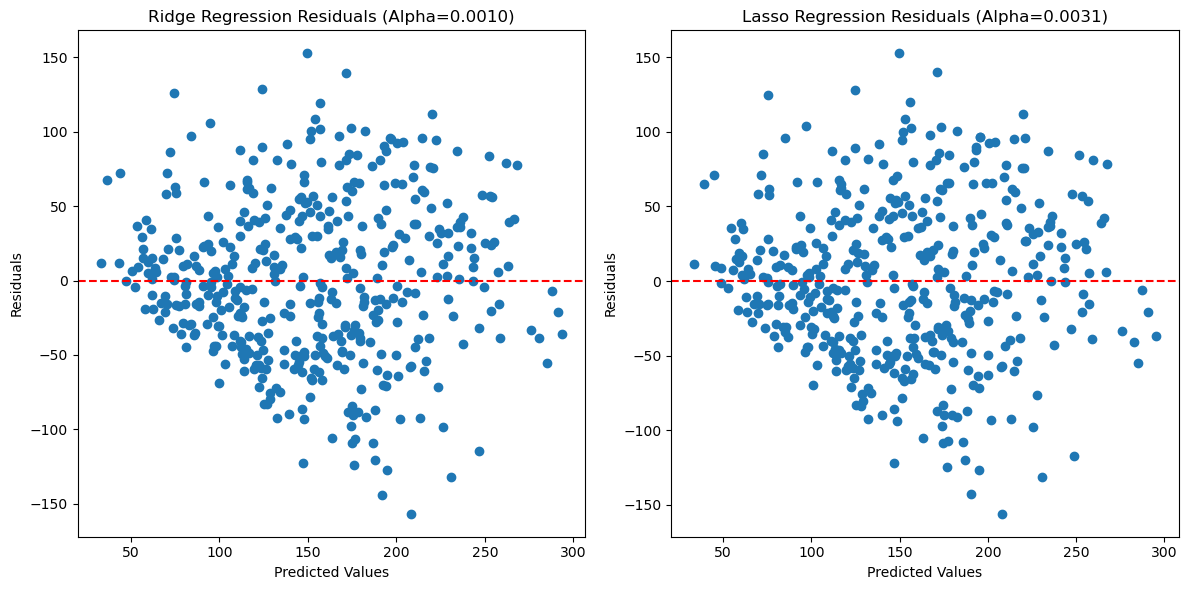

Best Ridge Alpha: 0.001
Best Lasso Alpha: 0.0030538555088334154
Ridge MSE: 2866.9181561324604
Lasso MSE: 2868.55700497121


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

# Load the diabetes dataset from sklearn
diabetes = datasets.load_diabetes()
X = diabetes.data[:, :-1]  # Use all features except the last one
y = diabetes.target  # Target variable (diabetes progression)

# Define a range of alpha values for Ridge and Lasso regularization
alphas = np.logspace(-3, 3, 100)  # Logarithmically spaced values from 0.001 to 1000

# Perform Ridge regression with cross-validation to find the best alpha
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)
best_ridge_alpha = ridge_cv.best_params_['alpha']  # Get the best alpha value
ridge_best = Ridge(alpha=best_ridge_alpha)  # Train Ridge with the best alpha
ridge_best.fit(X, y)

# Perform Lasso regression with cross-validation to find the best alpha
lasso = Lasso(max_iter=10000)  # Allow Lasso to run more iterations if needed
lasso_cv = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)
best_lasso_alpha = lasso_cv.best_params_['alpha']  # Get the best alpha value
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000)  # Train Lasso with the best alpha
lasso_best.fit(X, y)

# Plot Ridge and Lasso coefficients as a function of the regularization parameter (alpha)
plt.figure(figsize=(12, 6))

# Ridge regression plot
plt.subplot(1, 2, 1)
for i in range(X.shape[1]):
    plt.plot(alphas, [Ridge(alpha=a).fit(X, y).coef_[i] for a in alphas], label=f'Feature {i+1}')
plt.xscale('log')  # Logarithmic x-axis for alpha
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficients')
plt.legend()

# Lasso regression plot
plt.subplot(1, 2, 2)
for i in range(X.shape[1]):
    plt.plot(alphas, [Lasso(alpha=a, max_iter=10000).fit(X, y).coef_[i] for a in alphas], label=f'Feature {i+1}')
plt.xscale('log')  # Logarithmic x-axis for alpha
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Coefficient Values')
plt.title('Lasso Regression Coefficients')
plt.legend()

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Make predictions using the best Ridge and Lasso models
ridge_pred = ridge_best.predict(X)
lasso_pred = lasso_best.predict(X)

# Calculate residuals (difference between actual and predicted values)
ridge_residuals = y - ridge_pred
lasso_residuals = y - lasso_pred

# Plot residuals for Ridge and Lasso models
plt.figure(figsize=(12, 6))

# Ridge regression residual plot
plt.subplot(1, 2, 1)
plt.scatter(ridge_pred, ridge_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at residual=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Ridge Regression Residuals (Alpha={best_ridge_alpha:.4f})')

# Lasso regression residual plot
plt.subplot(1, 2, 2)
plt.scatter(lasso_pred, lasso_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at residual=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Lasso Regression Residuals (Alpha={best_lasso_alpha:.4f})')

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Print the best alpha values and mean squared error (MSE) for both Ridge and Lasso models
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Lasso Alpha: {best_lasso_alpha}")
print(f"Ridge MSE: {mean_squared_error(y, ridge_pred)}")
print(f"Lasso MSE: {mean_squared_error(y, lasso_pred)}")


#### Explanation of Parameter Convergence in Lasso vs. Ridge Regression

##### 1. **Regularization Techniques Overview**:
- **Lasso Regression** (L1 regularization) and **Ridge Regression** (L2 regularization) are both techniques used to prevent overfitting in linear regression models by adding a penalty term to the loss function.
- The primary difference lies in the type of penalty applied:
  - **Lasso**: Adds the absolute value of the coefficients (L1 norm) to the loss function.
  - **Ridge**: Adds the squared value of the coefficients (L2 norm) to the loss function.

##### 2. **Impact of Alpha**:
- The hyperparameter **alpha** controls the strength of the regularization. As **alpha** increases, the penalty for large coefficients becomes stronger in both methods.

##### 3. **Lasso’s Accelerated Convergence to Zero**:
- **Geometric Interpretation**: 
  - In Lasso, the constraint forms a diamond-shaped boundary (due to the L1 norm), which intersects the contours of the loss function in a more pointed manner. As alpha increases, the feasible region shrinks rapidly, leading to faster convergence of coefficients to zero.
  - In contrast, Ridge’s constraint creates a circular boundary (due to the L2 norm), which intersects the contours of the loss function more gradually, causing coefficients to shrink but not necessarily to zero.

##### 4. **Sparsity Induction**:
- Lasso tends to produce sparse solutions, meaning that it can force some coefficients exactly to zero. This is because the L1 penalty has a unique property of encouraging sparsity by effectively "selecting" important features while eliminating others.
- Ridge, while it does reduce coefficients, typically retains all features in the model, just shrinking their values.

##### 5. **Mathematical Intuition**:
- The optimization problem for Lasso is:
  $$
  \min \left( \frac{1}{2} ||y - X\beta||^2_2 + \alpha ||\beta||_1 \right)
  $$
- For Ridge, it is:
  $$
  \min \left( \frac{1}{2} ||y - X\beta||^2_2 + \alpha ||\beta||_2^2 \right)
  $$
- The linear penalty in Lasso means that large coefficients are penalized more severely, leading to a more pronounced reduction as alpha increases. 

##### 6. **Conclusion**:
- In summary, Lasso regression converges to zero more quickly and steeply than Ridge regression as alpha increases due to its L1 penalty inducing sparsity and the geometric nature of the constraints. This makes Lasso particularly useful for feature selection in high-dimensional datasets.